<a href="https://colab.research.google.com/github/chefPony/nn_zero_to_hero/blob/master/makemore_part5_wavenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from collections import deque
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
!wget https://raw.githubusercontent.com/chefPony/nn_zero_to_hero/master/makemore/data/names_usa.txt

--2024-08-31 12:26:50--  https://raw.githubusercontent.com/chefPony/nn_zero_to_hero/master/makemore/data/names_usa.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names_usa.txt’

names_usa.txt       100%[===================>] 222.80K  --.-KB/s    in 0.03s   

2024-08-31 12:26:51 (6.33 MB/s) - ‘names_usa.txt’ saved [228145/228145]



In [3]:
# read in all the words
words = open('names_usa.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [23]:
# build dataset
context_length = 8

def build_dataset(words: list, vocabulary: dict, context_length: int):
  X, Y = [], []
  for w in words:
    context = deque([vocabulary['.']] * context_length)
    for x in w + '.':
      Y.append(vocabulary[x])
      X.append(list(context))
      context.popleft()
      context.append(vocabulary[x])

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1], stoi, context_length)     # 80%
Xdev, Ydev = build_dataset(words[n1:n2], stoi, context_length)   # 10%
Xte,  Yte  = build_dataset(words[n2:], stoi, context_length)     # 10%

In [54]:
# Check
for x, y in zip(Xdev[:10], Ydev):
  print(''.join(itos[i.item()] for i in x), '-->', itos[y.item()])

........ --> a
.......a --> m
......am --> a
.....ama --> y
....amay --> .
........ --> a
.......a --> y
......ay --> t
.....ayt --> a
....ayta --> n


In [46]:
# Layers

class Linear:
  def __init__(self, in_features, out_features, bias=True):
    self.bias = bias
    self.W = torch.randn((in_features, out_features)) / (in_features ** 0.5)
    if self.bias:
      self.b = torch.zeros(out_features)
    else:
      self.b = None

  def __call__(self, x):
    self.out = x @ self.W
    if self.bias:
      self.out += self.b
    return self.out

  def parameters(self):
    return [self.W, self.b] if self.bias else [self.W]

test = Linear(Xtr.shape[1], 12, True)(Xtr[:4, :].float())
assert(test.shape == (4, 12))


class BatchNorm1d:

  def __init__(self, dim, momentum = 0.1, eps = 1e-6):
    self.gamma = torch.randn((1, dim))
    self.beta = torch.randn((1, dim))
    self.mu = torch.zeros((1, dim))
    self.sigma = torch.zeros((1, dim))
    self.momentum = momentum
    self.eps = eps
    self.training = True

  def __call__(self, x):
    if self.training:
      if len(x.shape) == 2:
        batch_mean = torch.mean(x, dim=0)
        batch_sigma = torch.std(x, dim=0)
      elif len(x.shape) == 3:
        batch_mean = torch.mean(x, dim=(0, 1))
        batch_sigma = torch.std(x, dim=(0, 1))
      else:
        raise ValueError

      self.out = (x - batch_mean)/torch.sqrt(batch_sigma + self.eps)
      with torch.no_grad():
        self.mu = (1 - self.momentum) * batch_mean + self.momentum * self.mu
        self.sigma = (1 - self.momentum) * batch_sigma + self.momentum * self.sigma
    else:
      self.out = (x - self.mu)/torch.sqrt(self.sigma + self.eps)

    self.out = self.gamma * self.out + self.beta
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

  def set_training(self, tr: bool):
    self.training = tr


l = BatchNorm1d(12)
test_x = torch.randn((4, 4, 12))
test_out = l(test_x)
assert(test_out.shape == (4, 4, 12))
l.set_training(False)
test_out = l(test_x)
assert(test_out.shape == (4, 4, 12))


class Tanh:

  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []


class Embedding:

  def __init__(self, num_embeddings, embedding_dim):
    self.n_emb = num_embeddings
    self.dim = embedding_dim
    self.C = torch.randn((self.n_emb, self.dim))

  def __call__(self, x):
    B, C = x.shape
    self.out = self.C[x]
    #self.out = self.out.reshape((B, C, self.dim))
    return self.out

  def parameters(self):
    return [self.C]

test_x = Xtr[:4, :]
l = Embedding(vocab_size, 10)
test_out = l(test_x)
assert(test_out.shape == (4, 8, 10))

class FlattenConsecutive:

  def __init__(self, n: int):
    self.n = n

  def __call__(self, x):
    B, T, C = x.shape
    x = x.view((B, T//self.n, C * self.n))
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out

  def parameters(self):
    return []

test_x = torch.randn((4, 8, 10))
l = FlattenConsecutive(n=2)
test_out = l(test_x)
assert(test_out.shape == (4, 4, 20))


class Sequential:
  def __init__(self, layers: list):
    self.layers = layers

  def __call__(self, x):
    self.out = x
    for l in self.layers:
      self.out = l(self.out)
    return self.out

  def parameters(self):
    return [p for l in self.layers for p in l.parameters() ]


In [11]:
# Set seed
torch.manual_seed(42)

In [55]:
# Network
num_embeddings = vocab_size
dim_embeddings = 24
hidden_dim = 128

model = Sequential(layers=[
    Embedding(num_embeddings, dim_embeddings),
    FlattenConsecutive(n=2),Linear(dim_embeddings * 2, hidden_dim, False),BatchNorm1d(hidden_dim), Tanh(),
    FlattenConsecutive(n=2),Linear(hidden_dim * 2, hidden_dim, False),BatchNorm1d(hidden_dim), Tanh(),
    FlattenConsecutive(n=2),Linear(hidden_dim * 2, hidden_dim, False),BatchNorm1d(hidden_dim), Tanh(),
    Linear(hidden_dim, vocab_size)
])

# parameter init
with torch.no_grad():
  model.layers[-1].W *= 0.1 # last layer make less confident

print(f"Number of parameters {sum([p.nelement() for p in model.parameters()])}")
for p in model.parameters():
  p.requires_grad = True

Number of parameters 76579


In [56]:
# Training loop
batch_size = 32
n_iter = 200000
lr = 0.1

loss_tracker = list()
for i in range(n_iter):
  ix = torch.randint(0, Xtr.shape[0], size=(batch_size, ))
  xb, yb = Xtr[ix], Ytr[ix]

  logits = model(xb)
  loss = F.cross_entropy(logits, yb)

  for p in model.parameters():
    p.grad = None

  loss.backward()

  if i > 150000:
    lr = 0.01

  for p in model.parameters():
    p.data += - lr * p.grad

  loss_tracker.append(loss.log10().item())
  if i % 10000 == 0:
    print(f"{i}/{n_iter}  {loss.item()}")

0/200000  3.297420024871826
10000/200000  1.9009685516357422
20000/200000  1.6694543361663818
30000/200000  1.8465951681137085
40000/200000  1.8007925748825073
50000/200000  2.100294828414917
60000/200000  1.9570350646972656
70000/200000  1.8522686958312988
80000/200000  1.6944615840911865
90000/200000  1.928874135017395
100000/200000  1.624273657798767
110000/200000  2.167072296142578
120000/200000  2.293593406677246
130000/200000  2.3259012699127197
140000/200000  1.964626669883728
150000/200000  2.007993698120117
160000/200000  1.7684580087661743
170000/200000  1.9936727285385132
180000/200000  1.7248011827468872
190000/200000  1.8408355712890625


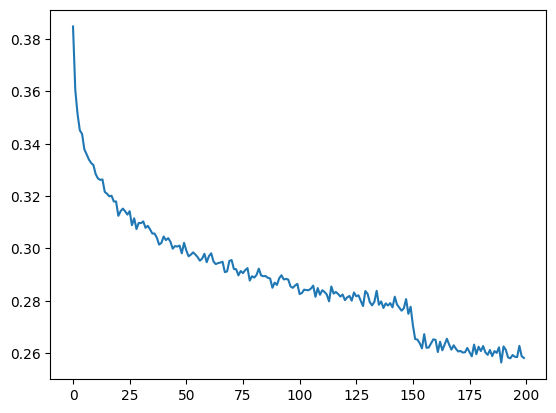

In [57]:
loss_tracker = torch.tensor(loss_tracker)
rolling_avg = loss_tracker.view(-1, 1000, 1).mean(dim=1)
plt.plot(rolling_avg)

In [58]:
# loss evaluation
@torch.no_grad()
def eval_on_split(split):
  X, Y = {"train": (Xtr, Ytr), "dev": (Xdev, Ydev), "test": (Xte, Yte)}[split]
  Yhat = model(X)
  loss = F.cross_entropy(Yhat, Y)
  return loss.item()

print(f"Train loss: {eval_on_split('train'):.6f}")
print(f"Dev loss: {eval_on_split('dev'):.6f}")
print(f"Test loss: {eval_on_split('test'):.6f}")

Train loss: 1.794186
Dev loss: 1.993524
Test loss: 1.992829


In [59]:
for l in model.layers:
  l.training = False

name = list()
next_s = None
with torch.no_grad():
    context = deque([stoi['.'] for _ in range(context_length)])
    while next_s != '.':
      logits = model(torch.tensor(context).view((1, -1)))
      next_i = torch.multinomial(logits.exp()/logits.exp().sum(), num_samples=1).item()
      next_s = itos[next_i]
      name.append(next_s)
      context.popleft()
      context.append(next_i)
      print("".join(name))



a
ad
ade
aden
adeni
adenik
adenika
adenika.
